In [107]:
import cv2
import os
import numpy as np
import pandas as pd
import pytesseract
from pytesseract import Output
import matplotlib.pyplot as plt
pytesseract.pytesseract.tesseract_cmd="/home/aman/anaconda3/envs/tallyInvoiceParser.env/bin/tesseract"
os.environ['TESSDATA_PREFIX'] = "/home/aman/anaconda3/envs/tallyInvoiceParser.env/share/tessdata"
os.environ['MLIR_CRASH_REPRODUCER_DIRECTORY']='tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269'
import import_ipynb
from imagePreProcessor import *
import math
from sklearn.model_selection import train_test_split
import keras
from keras import models
from keras.models import Sequential
from keras.layers import Dense, ReLU, activation, Dropout
import tensorflow as tf
import datefinder
import dateparser

In [108]:
pwd

'/home/aman/Documents/Tally/Git-Document-AI/Document-AI/InvoiceDateModel-v2/Dataset'

In [109]:
os.chdir('/home/aman/Documents/Tally/Git-Document-AI/Document-AI/InvoiceDateModel-v2/Dataset/')

In [110]:
df = pd.read_csv("tesseract.csv")

In [111]:
df.drop_duplicates(subset=["x", "y", "imageName"], keep="first", inplace=True)

In [112]:
df.shape

(124, 30)

In [113]:
df.describe()

,Unnamed: 0,block_num,line_num,left,top,width,height,conf,x,y,...,invoice,delivery,order,due,payment,tax,bill,receipt,issue,output
count,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,...,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000
mean,92.064516,9.290323,1.790323,1238.338710,1168.266129,229.693548,33.653226,84.391958,1468.032258,1201.919355,...,557.646630,147.633633,102.024125,115.157891,177.328995,680.921835,428.680619,20.364179,14.815863,0.419355
std,53.897183,8.595493,3.527532,736.752067,838.168349,184.025678,7.411312,16.716716,708.793696,838.845806,...,606.224805,523.030673,390.963097,306.608087,468.005785,801.055870,786.865160,110.618704,75.168796,0.495455
min,0.000000,1.000000,0.000000,73.000000,67.000000,72.000000,18.000000,0.000000,210.000000,97.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.500000,4.000000,0.000000,560.500000,574.750000,166.250000,29.000000,79.415279,839.750000,616.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,94.000000,6.500000,1.000000,1150.500000,843.000000,189.000000,32.500000,90.290752,1408.000000,872.500000,...,389.698446,0.000000,0.000000,0.000000,0.000000,458.453030,0.000000,0.000000,0.000000,0.000000
75%,137.250000,11.000000,2.000000,1891.250000,1554.000000,224.500000,37.250000,96.286427,2113.000000,1584.000000,...,724.088892,0.000000,0.000000,0.000000,0.000000,1050.048512,448.026705,0.000000,0.000000,1.000000
max,183.000000,46.000000,26.000000,3319.000000,3925.000000,1696.000000,71.000000,96.915260,3391.000000,3961.000000,...,2614.345999,3199.536529,2622.190306,2127.643062,3019.951324,3654.836795,3672.623722,892.261173,500.144979,1.000000


In [114]:
len(df["imageName"].unique())

51

In [115]:
def preProcess(df):
    for index in df.index:
        
        x = df["x"][index]
        y = df["y"][index]
        X = df["PageWidth"][index]
        X = X/2
        Y = df["PageHeight"][index]
        Y = Y/2
        
        if x<X:
            df["isLeft"][index]=1
        elif x>=X:
            df["isRight"][index]=1
            
        if y>Y:
            df["isBottom"][index]=1
        elif y<Y:
            df["isTop"][index]=1
            
        
            
    df["x"]/=df["PageWidth"]
    df["y"]/=df["PageHeight"]

    df["conf"]/=100

    neighbourFields = ["date", "dated", "invoice", "delivery", "order", "due", "payment", "tax", "bill", "receipt", "issue"]

    for col in neighbourFields:
        df[col]/=4000
    
    colsToDrop = ["Unnamed: 0", "left", "top", "width", "height", "imageName", "text", "PageHeight", "PageWidth"]
    df.drop(columns=colsToDrop, inplace=True)
    

In [116]:
preProcess(df)

/tmp/ipykernel_16192/3378690190.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["isRight"][index]=1
/tmp/ipykernel_16192/3378690190.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["isTop"][index]=1
/tmp/ipykernel_16192/3378690190.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["isBottom"][index]=1
/tmp/ipykernel_16192/3378690190.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [117]:
df

,block_num,line_num,conf,x,y,isTop,isBottom,isRight,isLeft,date,...,invoice,delivery,order,due,payment,tax,bill,receipt,issue,output
0,6,2,0.966901,0.815651,0.220924,1,0,1,0,0.000000,...,0.077500,0.0,0.0,0.000000,0.000000,0.113500,0.000000,0.000000,0.0,1
2,27,1,0.956715,0.961678,0.678857,0,1,1,0,0.054005,...,0.479420,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.072002,0.0,0
3,8,0,0.731196,0.828963,0.090000,1,0,1,0,0.000000,...,0.155250,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
4,8,0,0.800068,0.790238,0.144286,1,0,1,0,0.000000,...,0.112286,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
5,11,0,0.868500,0.450988,0.216571,1,0,0,1,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,6,2,0.540741,0.824314,0.238000,1,0,1,0,0.125190,...,0.150404,0.0,0.0,0.165576,0.000000,0.203135,0.000000,0.000000,0.0,0
180,11,1,0.667299,0.467451,0.528000,0,1,0,1,0.258487,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
181,11,1,0.968660,0.449194,0.199770,1,0,0,1,0.091311,...,0.174018,0.0,0.0,0.000000,0.203500,0.217007,0.000000,0.000000,0.0,0
182,11,2,0.961782,0.445565,0.200918,1,0,0,1,0.093750,...,0.172417,0.0,0.0,0.000000,0.201252,0.215240,0.000000,0.000000,0.0,0


In [118]:
df.drop(columns=["block_num", "delivery", "order", "issue", "conf"], inplace=True)

In [119]:
df.describe()

,line_num,x,y,isTop,isBottom,isRight,isLeft,date,dated,invoice,due,payment,tax,bill,receipt,output
count,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000
mean,1.790323,0.552995,0.342699,0.766129,0.233871,0.516129,0.483871,0.087487,0.038360,0.139412,0.028789,0.044332,0.170230,0.107170,0.005091,0.419355
std,3.527532,0.256095,0.227847,0.425008,0.425008,0.501767,0.501767,0.164085,0.138749,0.151556,0.076652,0.117001,0.200264,0.196716,0.027655,0.495455
min,0.000000,0.059795,0.019529,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.336765,0.171042,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.507865,0.254242,1.000000,0.000000,1.000000,0.000000,0.036298,0.000000,0.097425,0.000000,0.000000,0.114613,0.000000,0.000000,0.000000
75%,2.000000,0.816156,0.473366,1.000000,0.000000,1.000000,1.000000,0.101672,0.000000,0.181022,0.000000,0.000000,0.262512,0.112007,0.000000,1.000000
max,26.000000,0.961678,0.978286,1.000000,1.000000,1.000000,1.000000,0.986337,0.860789,0.653586,0.531911,0.754988,0.913709,0.918156,0.223065,1.000000


In [120]:
df.corr()

,line_num,x,y,isTop,isBottom,isRight,isLeft,date,dated,invoice,due,payment,tax,bill,receipt,output
line_num,1.000000,-0.062768,0.176291,-0.087203,0.087203,-0.039413,0.039413,-0.010646,-0.018494,0.061793,0.145707,0.069881,0.040951,0.056954,-0.029748,-0.181870
x,-0.062768,1.000000,-0.070441,0.062561,-0.062561,0.895288,-0.895288,0.168034,0.128912,0.332221,0.086542,0.121839,0.220309,0.206353,0.227448,0.184620
y,0.176291,-0.070441,1.000000,-0.864841,0.864841,-0.031135,0.031135,0.291836,0.308333,0.387889,0.210055,0.353806,0.503863,0.247782,-0.075686,-0.443466
isTop,-0.087203,0.062561,-0.864841,1.000000,-1.000000,0.036894,-0.036894,-0.405417,-0.365832,-0.406504,-0.231407,-0.436236,-0.433326,-0.305311,0.052321,0.315102
isBottom,0.087203,-0.062561,0.864841,-1.000000,1.000000,-0.036894,0.036894,0.405417,0.365832,0.406504,0.231407,0.436236,0.433326,0.305311,-0.052321,-0.315102
isRight,-0.039413,0.895288,-0.031135,0.036894,-0.036894,1.000000,-1.000000,0.225406,0.210032,0.294629,0.018480,0.097921,0.243837,0.192921,0.178971,0.168790
isLeft,0.039413,-0.895288,0.031135,-0.036894,0.036894,-1.000000,1.000000,-0.225406,-0.210032,-0.294629,-0.018480,-0.097921,-0.243837,-0.192921,-0.178971,-0.168790
date,-0.010646,0.168034,0.291836,-0.405417,0.405417,0.225406,-0.225406,1.000000,0.838006,0.411886,0.116499,0.630323,0.547880,0.537127,-0.076164,-0.208841
dated,-0.018494,0.128912,0.308333,-0.365832,0.365832,0.210032,-0.210032,0.838006,1.000000,0.353803,-0.068479,0.618449,0.607618,0.606930,-0.051311,-0.192221
invoice,0.061793,0.332221,0.387889,-0.406504,0.406504,0.294629,-0.294629,0.411886,0.353803,1.000000,0.386059,0.411691,0.686432,0.431696,-0.076069,-0.170987


In [121]:
df.shape

(124, 16)

In [122]:
len(df[df["output"]==0])

72

In [123]:
len(df[df["output"]==1])

52

In [124]:
# dfTrue = df[df["output"]==1].sample(frac=1)[:52]
# dfFalse = df[df["output"]==0].sample(frac=1)[:52]
# df = pd.concat([dfTrue, dfFalse], axis=0).sample(frac=1)
# df


In [125]:
df.corr()

,line_num,x,y,isTop,isBottom,isRight,isLeft,date,dated,invoice,due,payment,tax,bill,receipt,output
line_num,1.000000,-0.062768,0.176291,-0.087203,0.087203,-0.039413,0.039413,-0.010646,-0.018494,0.061793,0.145707,0.069881,0.040951,0.056954,-0.029748,-0.181870
x,-0.062768,1.000000,-0.070441,0.062561,-0.062561,0.895288,-0.895288,0.168034,0.128912,0.332221,0.086542,0.121839,0.220309,0.206353,0.227448,0.184620
y,0.176291,-0.070441,1.000000,-0.864841,0.864841,-0.031135,0.031135,0.291836,0.308333,0.387889,0.210055,0.353806,0.503863,0.247782,-0.075686,-0.443466
isTop,-0.087203,0.062561,-0.864841,1.000000,-1.000000,0.036894,-0.036894,-0.405417,-0.365832,-0.406504,-0.231407,-0.436236,-0.433326,-0.305311,0.052321,0.315102
isBottom,0.087203,-0.062561,0.864841,-1.000000,1.000000,-0.036894,0.036894,0.405417,0.365832,0.406504,0.231407,0.436236,0.433326,0.305311,-0.052321,-0.315102
isRight,-0.039413,0.895288,-0.031135,0.036894,-0.036894,1.000000,-1.000000,0.225406,0.210032,0.294629,0.018480,0.097921,0.243837,0.192921,0.178971,0.168790
isLeft,0.039413,-0.895288,0.031135,-0.036894,0.036894,-1.000000,1.000000,-0.225406,-0.210032,-0.294629,-0.018480,-0.097921,-0.243837,-0.192921,-0.178971,-0.168790
date,-0.010646,0.168034,0.291836,-0.405417,0.405417,0.225406,-0.225406,1.000000,0.838006,0.411886,0.116499,0.630323,0.547880,0.537127,-0.076164,-0.208841
dated,-0.018494,0.128912,0.308333,-0.365832,0.365832,0.210032,-0.210032,0.838006,1.000000,0.353803,-0.068479,0.618449,0.607618,0.606930,-0.051311,-0.192221
invoice,0.061793,0.332221,0.387889,-0.406504,0.406504,0.294629,-0.294629,0.411886,0.353803,1.000000,0.386059,0.411691,0.686432,0.431696,-0.076069,-0.170987


In [126]:
def extractData(df):
    train, test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
    xTrain = train.drop(columns = ["output"]).to_numpy()
    xTest = test.drop(columns = ["output"]).to_numpy()
    yTrain = train["output"].to_numpy()
    yTest = test["output"].to_numpy()
    return xTrain, yTrain, xTest, yTest

In [127]:
xTrain, yTrain, xTest, yTest = extractData(df)

In [128]:
xTrain.shape

(99, 15)

In [129]:
xTest.shape

(25, 15)

In [130]:
yTrain.shape

(99,)

In [131]:
yTest.shape

(25,)

In [132]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [133]:
xgb = XGBClassifier(objective = "binary:hinge", eval_metric = "error")

In [134]:
xgb.fit(xTrain, yTrain)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='binary:hinge', predictor=None, ...)

In [135]:
pred = xgb.predict(xTest)
pred

array([0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0])

In [136]:
yTest

array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0])

In [138]:
acc = accuracy_score(pred, yTest)
acc

0.6

In [139]:
X = [x for x in range(len(xTest))]

In [140]:
len(X)

25

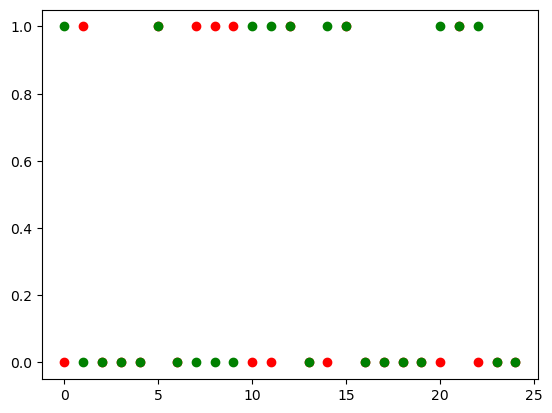

In [141]:
plt.scatter(X, pred, color="red")
plt.scatter(X, yTest, color="green")
plt.show()

In [142]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [143]:
from sklearn.model_selection import cross_val_score

In [167]:
def crossVal(classifier, num_splits):
    scores = cross_val_score(classifier, X, y, cv = num_splits)
    print("Accuracy Scores : ", scores)
    print("Mean Accuracy Score : ", scores.mean())

In [169]:
crossVal(xgb, 5)

Accuracy Scores :  [0.52 0.76 0.64 0.56 0.75]
Mean Accuracy Score :  0.646


In [170]:
params = {
    "n_estimators" : [150, 200, 250],
    "max_depth" : [3, 2, 1],
    "learning_rate" : [0.015, 0.01, 0.009],
    "num_parallel_tree" : [2, 3, 4],
    "reg_alpha" : [0.9, 1, 1.1],
    "reg_lambda" : [0.3, 0.4, 0.5]
}

In [160]:
from sklearn.model_selection import RandomizedSearchCV

In [161]:
gridXGB = RandomizedSearchCV(xgb, params,n_iter=100, cv=5, n_jobs=1, random_state=42)
gridXGB.fit(xTrain, yTrain)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='error',
                                           feature_types=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_r...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           objective='binary:hinge',
                                           predictor=None, ...),
                   n_iter=100, n_jobs=1,
                   param_distributions={'learning_rate': [0.015, 0.01, 0.009],
                                        'max_depth': [3, 2, 1],
                                        'n_estimators': [150, 200, 250],
                                        'num_parallel_tree': [2, 3, 4],
                                        'reg_alpha': [0.9, 1, 1.1],
                                        'reg_lambda': [0.3, 0.4, 0.5]},
                   random_state=42)

In [171]:
bestModel = gridXGB.best_estimator_
bestModel

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=250, n_jobs=None, num_parallel_tree=3,
              objective='binary:hinge', predictor=None, ...)

In [172]:
bestParams = gridXGB.best_params_
bestParams

{'reg_lambda': 0.3,
 'reg_alpha': 0.9,
 'num_parallel_tree': 3,
 'n_estimators': 250,
 'max_depth': 1,
 'learning_rate': 0.01}

In [173]:
yPred = bestModel.predict(xTest)

In [174]:
print(accuracy_score(yPred, yTest))

0.64


In [175]:
crossVal(bestModel, 5)

Accuracy Scores :  [0.6        0.84       0.68       0.72       0.66666667]
Mean Accuracy Score :  0.7013333333333333


In [176]:
bestModel.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=250, n_jobs=None, num_parallel_tree=3,
              objective='binary:hinge', predictor=None, ...)

In [177]:
crossVal(bestModel, 5)

Accuracy Scores :  [0.6        0.84       0.68       0.72       0.66666667]
Mean Accuracy Score :  0.7013333333333333
